In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
%pip install torch
%pip install kaggle
%pip install torchvision
%pip install scikit-image
%pip install numpy



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Dataset Preparation

In [6]:
#!kaggle datasets download -d requiemonk/sentinel12-image-pairs-segregated-by-terrain

In [7]:
# %%capture
# !unzip sentinel12-image-pairs-segregated-by-terrain.zip
# !rm -rf sentinel12-image-pairs-segregated-by-terrain.zip

In [8]:
import os
opt = []
sar = []
root_dir = '../v_2'
for dir in os.listdir(root_dir):
  path = os.path.join(root_dir, dir)
  s1, s2  = os.listdir(path)
  if s1 == 's2':
    print(s1)
    for file in os.listdir(os.path.join(path, s1)):
      if file.endswith('.png'):
        opt.append(os.path.join(path, s1, file))
    for file in os.listdir(os.path.join(path, s2)):
      if file.endswith('.png'):
        sar.append(os.path.join(path, s2, file))
  if s1 == 's1':
    for file in os.listdir(os.path.join(path, s1)):
      if file.endswith('.png'):
        sar.append(os.path.join(path, s1, file))
    for file in os.listdir(os.path.join(path, s2)):
      if file.endswith('.png'):
        opt.append(os.path.join(path, s2, file))
opt = sorted(opt)
sar = sorted(sar)
print(len(opt), len(sar))


16000 16000


# **Implementing Colorization Model**

In [10]:
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt



## Preparing dataset for colorization model

In [12]:
import cv2

def rgb_to_lab_cv2(pil_img):
    img_np = np.array(pil_img.convert("RGB")).astype("float32") / 255.0
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2Lab)
    
    # Convert to torch tensor and normalize
    img_lab = torch.from_numpy(img_lab.transpose(2, 0, 1)).float()  # shape [3, H, W]
    L = (img_lab[[0], ...] / 50.0) - 1.0
    ab = (img_lab[[1, 2], ...] - 128.0) / 128.0

    return L, ab
    

In [13]:
img = Image.open(opt[0]).resize((256, 256))
L, ab = rgb_to_lab_cv2(img)
print("L:", L.shape, "ab:", ab.shape)


L: torch.Size([1, 256, 256]) ab: torch.Size([2, 256, 256])


In [14]:
def create_patches(img, patch_size=224):
    patches = []
    h, w = img.shape[1:]

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[:, i:i + patch_size, j:j + patch_size]
            if patch.shape[1:] == (patch_size, patch_size):
                patches.append(patch)

    return patches

In [15]:
class ColorizationDataset(Dataset):
    def __init__(self, color_dir, transform=None, patch_size=224):
        self.color_dir = color_dir
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.color_dir)

    def __getitem__(self, idx):
        pil_img = Image.open(self.color_dir[idx]).convert("RGB").resize((224, 224))
        L, ab = rgb_to_lab_cv2(pil_img)
        return L, ab


In [16]:
dataset = ColorizationDataset(opt[:1000])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, drop_last=True)


In [17]:
# Load a batch and print the shapes of the patches
for L_patches, ab_patches in train_loader:
    print(f"L_patches shape: {L_patches.shape}")
    print(f"ab_patches shape: {ab_patches.shape}")
    print(L_patches[0])
    break

L_patches shape: torch.Size([8, 1, 224, 224])
ab_patches shape: torch.Size([8, 2, 224, 224])
tensor([[[-0.5271, -0.5283, -0.5426,  ..., -0.1525, -0.1548, -0.1566],
         [-0.6339, -0.6213, -0.5721,  ..., -0.1930, -0.1665, -0.1904],
         [-0.6472, -0.6472, -0.6414,  ..., -0.2190, -0.1923, -0.1738],
         ...,
         [-0.2212, -0.1898, -0.1528,  ..., -0.3651, -0.3645, -0.3840],
         [-0.2148, -0.1914, -0.1792,  ..., -0.3939, -0.3943, -0.3999],
         [-0.2087, -0.2087, -0.2111,  ..., -0.4369, -0.4132, -0.4275]]])


## Implementing the Encoder

In [19]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights, DenseNet121_Weights

class EnsembleEncoder(nn.Module):
    def __init__(self):
        super(EnsembleEncoder, self).__init__()

        # Load pre-trained ResNet50 and DenseNet121
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.densenet121 = models.densenet121(weights=DenseNet121_Weights.DEFAULT)

        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
        # self.densenet121 = nn.Sequential(*list(self.densenet121.children())[:-1])
        self.densenet121.classifier = nn.Identity()


        # Custom layers for fusion
        self.conv1x1_resnet50 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(2048, 1024, kernel_size=1)
        ])

        self.conv1x1_densenet121 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(1024, 1024, kernel_size=1)
        ])

        self.fusion_blocks = nn.ModuleList([
            self.fusion_block(128, 128),
            self.fusion_block(256, 256),
            self.fusion_block(512, 512),
            self.fusion_block(1024, 1024)
        ])

    # Fusion block
    def fusion_block(self, in_channels_resnet, in_channels_densenet):
        return nn.Sequential(
            nn.Conv2d(in_channels_resnet + in_channels_densenet, in_channels_resnet, kernel_size=1),
            nn.BatchNorm2d(in_channels_resnet),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass through ResNet50
        resnet_features = []
        resnet_input = x
        for i, layer in enumerate(self.resnet50.children()):
            resnet_input = layer(resnet_input)
            if i in [4, 5, 6, 7]:  # Extract features after specific layers
                resnet_features.append(self.conv1x1_resnet50[i-4](resnet_input))

        # Forward pass through DenseNet121
        densenet_features = []
        idx = 0
        densenet_input = x
        for i, layer in enumerate(self.densenet121.features):
            densenet_input = layer(densenet_input)
            if i in [ 4, 6, 8, 11]:
                densenet_features.append(self.conv1x1_densenet121[idx](densenet_input))
                idx += 1


        fused_features = []
        for i in range(4):
            fused = torch.cat((resnet_features[i], densenet_features[i]), dim=1)
            fused = self.fusion_blocks[i](fused)
            fused_features.append(fused)

        return fused_features


## Implementing the Decoder

In [21]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Decoder block 1: Takes input from Fusion Block 4
        self.decode1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 7x7 -> 14x14
        )

        # Decoder block 2: Takes input from Decoder Block 1 + Fusion Block 3 (512 + 512 channels)
        self.decode2 = nn.Sequential(
            nn.Conv2d(512 + 512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 14x14 -> 28x28
        )

        # Decoder block 3: Takes input from Decoder Block 2 + Fusion Block 2 (256 + 256 channels)
        self.decode3 = nn.Sequential(
            nn.Conv2d(256 + 256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 28x28 -> 56x56
        )

        # Decoder block 4: Takes input from Decoder Block 3 + Fusion Block 1 (128 + 128 channels)
        self.decode4 = nn.Sequential(
            nn.Conv2d(128 + 128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 56x56 -> 112x112
        )

        # Final decoder block: Reduce to 2 channels (ab channels)
        self.decode5 = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),            
            nn.BatchNorm2d(2),            
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 112x112 -> 224x224
        )

    def forward(self, features_7x7, features_14x14, features_28x28, features_56x56):
        x = self.decode1(features_7x7)
        x = torch.cat([x, features_14x14], dim=1)
        x = self.decode2(x)

        x = torch.cat([x, features_28x28], dim=1)
        x = self.decode3(x)

        x = torch.cat([x, features_56x56], dim=1)
        x = self.decode4(x)

        output = self.decode5(x)

        return output


## Checking our model

In [23]:
import torch
import torch.nn as nn

class ColorizationModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ColorizationModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        features_56x56, features_28x28, features_14x14, features_7x7 = self.encoder(x)

        output = self.decoder(features_7x7, features_14x14, features_28x28, features_56x56)

        return output

encoder = EnsembleEncoder().to(device)
decoder = Decoder().to(device)

model = ColorizationModel(encoder, decoder)

# input data
L_patches = torch.randn(1, 3, 224, 224).to(device)

output = model(L_patches)

print("Output shape:", output.shape)  # output shape should be [1, 2, 224, 224]


Output shape: torch.Size([1, 2, 224, 224])


## Training the model

In [25]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize encoder and decoder
encoder = EnsembleEncoder().to(device)
decoder = Decoder().to(device)

# Freeze the encoder parameters as they are pre-trained
for param in encoder.parameters():
    param.requires_grad = False

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training loop
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    encoder.eval()
    decoder.train()
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")
    for i, (L_batch, ab_batch) in enumerate(train_bar):
        L, ab = L_batch.to(device), ab_batch.to(device)
        L = L.repeat(1, 3, 1, 1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        features_56x56, features_28x28, features_14x14, features_7x7 = encoder(L)
        output = decoder(features_7x7, features_14x14, features_28x28, features_56x56)

        # Compute loss
        loss = criterion(output, ab)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

        # Update progress bar
        train_bar.set_postfix(loss=f"{running_loss/(i+1):.4f}")

    # Validation phase
    decoder.eval()
    val_loss = 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")
    with torch.no_grad():
        for i, (L_batch, ab_batch) in enumerate(val_bar):
            L, ab = L_batch.to(device), ab_batch.to(device)
            L = L.repeat(1, 3, 1, 1)  

            # Forward pass
            features_56x56, features_28x28, features_14x14, features_7x7 = encoder(L)
            output = decoder(features_7x7, features_14x14, features_28x28, features_56x56)

            # Compute validation loss
            loss = criterion(output, ab)
            val_loss += loss.item()

            val_bar.set_postfix(loss=f"{val_loss/(i+1):.4f}")

    # Calculate average losses
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(decoder.state_dict(), 'model_1.pth')
        print(f"Model saved with validation loss: {best_val_loss:.4f}")

    # Step the scheduler
    scheduler.step(avg_val_loss)

print("Training complete.")


Epoch 1/20 (Validation): 100%|████████████████████████████████████████████| 20/20 [00:05<00:00,  3.77it/s, loss=0.6993]


Epoch 1/20, Training Loss: 0.8160, Validation Loss: 0.6993
Model saved with validation loss: 0.6993


Epoch 2/20 (Validation): 100%|████████████████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s, loss=0.5257]


Epoch 2/20, Training Loss: 0.6704, Validation Loss: 0.5257
Model saved with validation loss: 0.5257


Epoch 3/20 (Validation): 100%|████████████████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s, loss=0.5470]


Epoch 3/20, Training Loss: 0.5714, Validation Loss: 0.5470


Epoch 4/20 (Validation): 100%|████████████████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s, loss=0.4501]


Epoch 4/20, Training Loss: 0.4874, Validation Loss: 0.4501
Model saved with validation loss: 0.4501


Epoch 5/20 (Validation): 100%|████████████████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s, loss=0.3282]


Epoch 5/20, Training Loss: 0.4273, Validation Loss: 0.3282
Model saved with validation loss: 0.3282


Epoch 6/20 (Validation): 100%|████████████████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s, loss=0.2697]


Epoch 6/20, Training Loss: 0.3781, Validation Loss: 0.2697
Model saved with validation loss: 0.2697


Epoch 7/20 (Validation): 100%|████████████████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s, loss=0.2462]


Epoch 7/20, Training Loss: 0.3225, Validation Loss: 0.2462
Model saved with validation loss: 0.2462


Epoch 8/20 (Validation): 100%|████████████████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s, loss=0.2390]


Epoch 8/20, Training Loss: 0.2931, Validation Loss: 0.2390
Model saved with validation loss: 0.2390


Epoch 9/20 (Validation): 100%|████████████████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s, loss=0.1663]


Epoch 9/20, Training Loss: 0.2554, Validation Loss: 0.1663
Model saved with validation loss: 0.1663


Epoch 10/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s, loss=0.2064]


Epoch 10/20, Training Loss: 0.2373, Validation Loss: 0.2064


Epoch 11/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s, loss=0.1341]


Epoch 11/20, Training Loss: 0.2130, Validation Loss: 0.1341
Model saved with validation loss: 0.1341


Epoch 12/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s, loss=0.1511]


Epoch 12/20, Training Loss: 0.1839, Validation Loss: 0.1511


Epoch 13/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s, loss=0.1541]


Epoch 13/20, Training Loss: 0.1649, Validation Loss: 0.1541


Epoch 14/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s, loss=0.1063]


Epoch 14/20, Training Loss: 0.1732, Validation Loss: 0.1063
Model saved with validation loss: 0.1063


Epoch 15/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s, loss=0.0895]


Epoch 15/20, Training Loss: 0.1631, Validation Loss: 0.0895
Model saved with validation loss: 0.0895


Epoch 16/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s, loss=0.1881]


Epoch 16/20, Training Loss: 0.1483, Validation Loss: 0.1881


Epoch 17/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s, loss=0.2450]


Epoch 17/20, Training Loss: 0.1367, Validation Loss: 0.2450


Epoch 18/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s, loss=0.0898]


Epoch 18/20, Training Loss: 0.1266, Validation Loss: 0.0898


Epoch 19/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:05<00:00,  4.00it/s, loss=0.0843]


Epoch 19/20, Training Loss: 0.1423, Validation Loss: 0.0843
Model saved with validation loss: 0.0843


Epoch 20/20 (Validation): 100%|███████████████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s, loss=0.2405]

Epoch 20/20, Training Loss: 0.1162, Validation Loss: 0.2405
Training complete.


In [26]:
torch.cuda.empty_cache()

## Load the model

In [28]:
decoder = Decoder().to(device)
decoder.load_state_dict(torch.load('model_1.pth', map_location=device))

<All keys matched successfully>

## Inference

In [30]:
# Get a batch from the test loader
dataiter = iter(test_loader)
L_batch, ab_batch = next(dataiter)
L_batch, ab_batch = next(dataiter)
L_batch, ab_batch = L_batch.to(device), ab_batch.to(device)
L_batch = L_batch.repeat(1, 3, 1, 1)

encoder.eval()
decoder.eval()
with torch.no_grad():
    features_56x56, features_28x28, features_14x14, features_7x7 = encoder(L_batch)

    predicted_ab = decoder(features_7x7, features_14x14, features_28x28, features_56x56)


In [47]:
L_batch = L_batch[:, 0, :, :]
L_batch = L_batch.unsqueeze(1)

L_batch = (L_batch + 1) * 0.5 * 100
predicted_ab = ((predicted_ab + 1) * 0.5 * (127 + 128)) - 128
ab_batch = ((ab_batch + 1) * 0.5 * (127 + 128)) - 128

# Combine L and ab channels
predicted_lab = torch.cat([L_batch, predicted_ab], dim=1)
real_lab = torch.cat([L_batch, ab_batch], dim=1)


predicted_lab = predicted_lab.cpu().numpy()
real_lab = real_lab.cpu().numpy()

In [55]:
print("L min/max:", L.min().item(), L.max().item())
print("ab_real min/max:", ab_real.min().item(), ab_real.max().item())
print("ab_pred min/max:", ab_pred.min().item(), ab_pred.max().item())


L min/max: 50.0 5041.14990234375
ab_real min/max: -21190.23046875 -13302.21875
ab_pred min/max: -13631.90234375 -11854.4765625


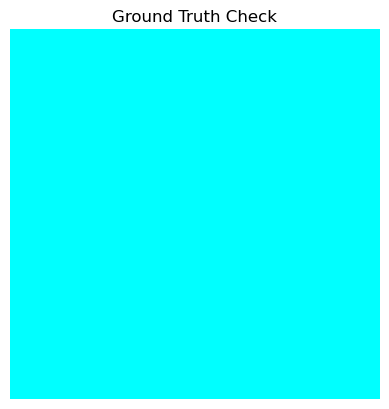

In [57]:
real_rgb = to_rgb_safe(L, ab_real)
plt.imshow(real_rgb)
plt.title("Ground Truth Check")
plt.axis("off")
plt.show()


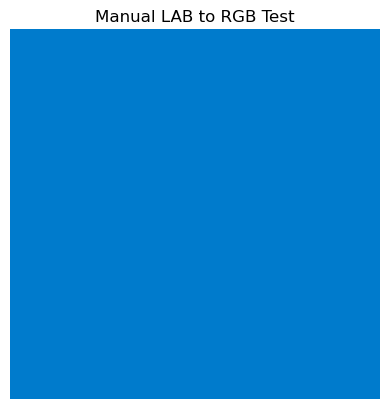

In [59]:
# Manual dummy LAB: mid-gray with blue tint
lab = np.zeros((224, 224, 3), dtype=np.float32)
lab[:, :, 0] = 50         # L: mid-brightness
lab[:, :, 1] = 0          # a: neutral
lab[:, :, 2] = -50        # b: blue tint

rgb = lab2rgb(lab)

plt.imshow(rgb)
plt.title("Manual LAB to RGB Test")
plt.axis("off")
plt.show()


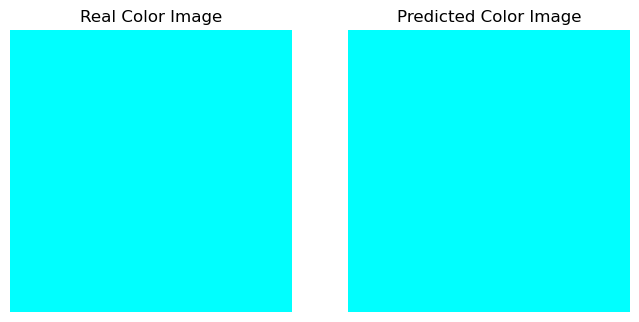

In [53]:
import numpy as np
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import torch

def to_rgb_safe(L_tensor, ab_tensor):
    # Remove batch dim
    L = L_tensor.squeeze(0).cpu().numpy()
    ab = ab_tensor.squeeze(0).cpu().numpy()

    # Denormalize properly
    L = (L + 1) * 50                # [0, 100]
    ab = ab * 127.5                 # [-128, 127]

    # Stack to (H, W, 3)
    lab = np.zeros((224, 224, 3), dtype=np.float32)
    lab[:, :, 0] = L[0]            # L channel
    lab[:, :, 1] = ab[0]           # a channel
    lab[:, :, 2] = ab[1]           # b channel

    # LAB to RGB
    rgb = lab2rgb(lab)
    return rgb

# Choose a sample
i = 0
L = L_batch[i].unsqueeze(0)
ab_real = ab_batch[i].unsqueeze(0)
ab_pred = predicted_ab[i].unsqueeze(0)

# Convert
real_rgb = to_rgb_safe(L, ab_real)
pred_rgb = to_rgb_safe(L, ab_pred)

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(real_rgb)
plt.title("Real Color Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_rgb)
plt.title("Predicted Color Image")
plt.axis("off")

plt.show()


## Evaulting the Model

In [ ]:
def prediction(model, test_loader):
    encoder.eval()
    model.eval()
    original_images = []
    predicted_images = []

    for L_batch, ab_batch in tqdm(test_loader):
        L_batch, ab_batch = L_batch.to(device), ab_batch.to(device)
        input = L_batch.repeat(1, 3, 1, 1)

        with torch.no_grad():
            features_56x56, features_28x28, features_14x14, features_7x7 = encoder(input)

            predicted_ab = model(features_7x7, features_14x14, features_28x28, features_56x56)            

        L_batch = (L_batch + 1) * 0.5 * 100        
        predicted_ab = ((predicted_ab + 1) * 0.5 * (127 + 128)) - 128
        ab_batch = ((ab_batch + 1) * 0.5 * (127 + 128)) - 128

        # Combine L and ab channels
        predicted_lab = torch.cat([L_batch, predicted_ab], dim=1)
        actual_lab = torch.cat([L_batch, ab_batch], dim=1)

        predicted_lab = predicted_lab.cpu().numpy()
        actual_lab = actual_lab.cpu().numpy()

        predicted_images.extend(predicted_lab)
        original_images.extend(actual_lab)

    return original_images, predicted_images

original_images, predicted_images = prediction(decoder, test_loader)

100%|██████████| 250/250 [00:30<00:00,  8.32it/s]


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.color import lab2rgb
import numpy as np

def evaluate_model(original_images, predicted_images):

    total_ssim = 0.0
    total_psnr = 0.0
    total_samples = 0
    for original_img, predicted_img in zip(original_images, predicted_images):
        original_img = lab2rgb(original_img.transpose(1, 2, 0))
        predicted_img = lab2rgb(predicted_img.transpose(1, 2, 0))

        ssim_value = ssim(original_img, predicted_img, multichannel=True, channel_axis=2, data_range=1.0)
        psnr_value = psnr(original_img, predicted_img, data_range=1.0)
        total_ssim += ssim_value
        total_psnr += psnr_value
        total_samples += 1

    average_ssim = total_ssim / total_samples
    average_psnr = total_psnr / total_samples

    return average_ssim, average_psnr

ssim_value, psnr_value = evaluate_model(original_images, predicted_images)
print(f"Average SSIM: {ssim_value:.4f}")
print(f"Average PSNR: {psnr_value:.4f}")



Average SSIM: 0.9400
Average PSNR: 29.9230


# Results

We are getting quite good results but after observing carefully we saw that the model is learning green color more than the other colors.